# Initialization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import attrs
import importlib

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
root_logdir = os.path.join(os.curdir, "logs")

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

def get_run_logdir(name=None):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") + f"- {name}"
    return os.path.join(root_logdir, run_id)

## Data initialization

In [3]:
dataset = pd.read_csv("data/train.csv")

In [4]:
dataset

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [5]:
dataset.shape

(10407, 4)

In [6]:
dataset["label"].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

## Data preparation

In [7]:
y = dataset["label"]
X = dataset.drop(columns=["label", "variety", "age"])

In [8]:
X.shape

(10407, 1)

In [9]:
y_labels = y.unique()
y_labels

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype=object)

In [10]:
label_transformer = LabelEncoder()

In [30]:
X_train, X_test, X_valid, y_train, y_test, y_valid = attrs.split_dataset(X, y)

In [31]:
y_train, y_test, y_valid = label_transformer.fit_transform(y_train), label_transformer.fit_transform(y_test), label_transformer.fit_transform(y_valid)

e:\Program files\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_valid.shape, y_valid.shape)

(((7492, 160, 120, 3), (7492,)),
 ((1041, 160, 120, 3), (1041,)),
 ((1874, 160, 120, 3), (1874,)))

# Training

## Model 1

In [34]:
model_1 = keras.Sequential()
model_1.add(keras.layers.Conv2D(48, 3, activation='relu', padding="same", input_shape=(X_train.shape[1], X_train.shape[2], 3)))
model_1.add(keras.layers.MaxPool2D(2))
model_1.add(keras.layers.BatchNormalization())

model_1.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_1.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_1.add(keras.layers.MaxPool2D(2))
model_1.add(keras.layers.BatchNormalization())

model_1.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_1.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_1.add(keras.layers.MaxPool2D(2))

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(384, activation="relu"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dropout(0.2))

model_1.add(keras.layers.Dense(192, activation="relu"))
model_1.add(keras.layers.Dense(96, activation="relu"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.Dense(48, activation="relu"))
model_1.add(keras.layers.Dense(10, activation="softmax"))

In [35]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/model_1_best.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("model_1"))
earlystopping_cb = keras.callbacks.EarlyStopping(patience=20)

model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model_1.fit(X_train, y_train, 
                        epochs=200, 
                        batch_size=24,
                        validation_data=(X_valid, y_valid), 
                        callbacks=[checkpoint_cb, tensorboard_cb, earlystopping_cb])

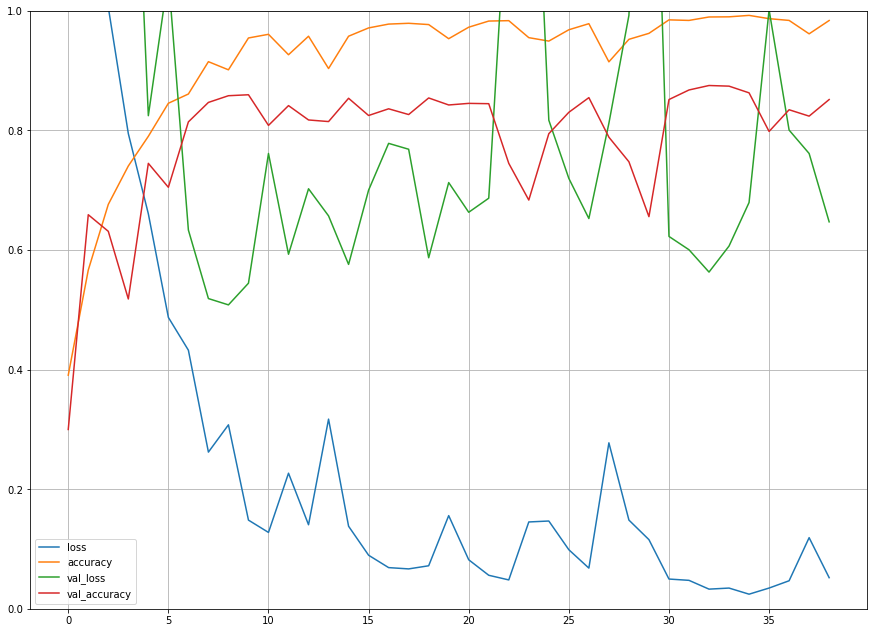

In [ ]:
pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_1.save("models/model_1.h5")
model_1.evaluate(X_test, y_test)

33/33 [==============================] - 5s 89ms/step - loss: 0.6757 - accuracy: 0.8569


[0.6757401823997498, 0.8568683862686157]

In [ ]:
model_1_ = keras.models.load_model("models/model_1_best.h5")
model_1_.evaluate(X_test, y_test)

33/33 [==============================] - 3s 58ms/step - loss: 0.5655 - accuracy: 0.8588


[0.5654973387718201, 0.8587896227836609]

In [ ]:
import gc
gc.collect()
tf.keras.backend.clear_session()

## Model 2

In [ ]:
model_2 = keras.Sequential()
model_2.add(keras.layers.Conv2D(48, 3, activation='relu', padding="same", input_shape=(X_train.shape[1], X_train.shape[2], 3)))
model_2.add(keras.layers.MaxPool2D(2))
model_2.add(keras.layers.BatchNormalization())

model_2.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_2.add(keras.layers.Conv2D(96, 3, activation='relu', padding="same"))
model_2.add(keras.layers.MaxPool2D(2))
model_2.add(keras.layers.BatchNormalization())

model_2.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_2.add(keras.layers.Conv2D(192, 3, activation='relu', padding="same"))
model_2.add(keras.layers.MaxPool2D(2))
model_2.add(keras.layers.BatchNormalization())

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(384, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dropout(0.2))

model_2.add(keras.layers.Dense(192, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dense(192, activation="relu"))
model_2.add(keras.layers.Dense(96, activation="relu"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dropout(0.2))
model_2.add(keras.layers.Dense(96, activation="relu"))
model_2.add(keras.layers.Dense(48, activation="relu"))
model_2.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/model_2_best.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("model_2"))
earlystopping_cb = keras.callbacks.EarlyStopping(patience=40)

model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model_2.fit(X_train, y_train, 
                        epochs=200, 
                        batch_size=24,
                        validation_data=(X_valid, y_valid), 
                        callbacks=[checkpoint_cb, tensorboard_cb, earlystopping_cb])

Epoch 1/200
313/313 [==============================] - 49s 139ms/step - loss: 1.8805 - accuracy: 0.3553 - val_loss: 2.2943 - val_accuracy: 0.3223
Epoch 2/200
313/313 [==============================] - 41s 132ms/step - loss: 1.3690 - accuracy: 0.5506 - val_loss: 1.6164 - val_accuracy: 0.4712
Epoch 3/200
313/313 [==============================] - 42s 133ms/step - loss: 1.1621 - accuracy: 0.6209 - val_loss: 1.4385 - val_accuracy: 0.5336
Epoch 4/200
313/313 [==============================] - 40s 127ms/step - loss: 0.9660 - accuracy: 0.6833 - val_loss: 1.8329 - val_accuracy: 0.4829
Epoch 5/200
313/313 [==============================] - 41s 130ms/step - loss: 0.7841 - accuracy: 0.7513 - val_loss: 5.5486 - val_accuracy: 0.2519
Epoch 6/200
313/313 [==============================] - 41s 132ms/step - loss: 0.6785 - accuracy: 0.7822 - val_loss: 0.7157 - val_accuracy: 0.7769
Epoch 7/200
313/313 [==============================] - 40s 129ms/step - loss: 0.5941 - accuracy: 0.8117 - val_loss: 1.1103 -

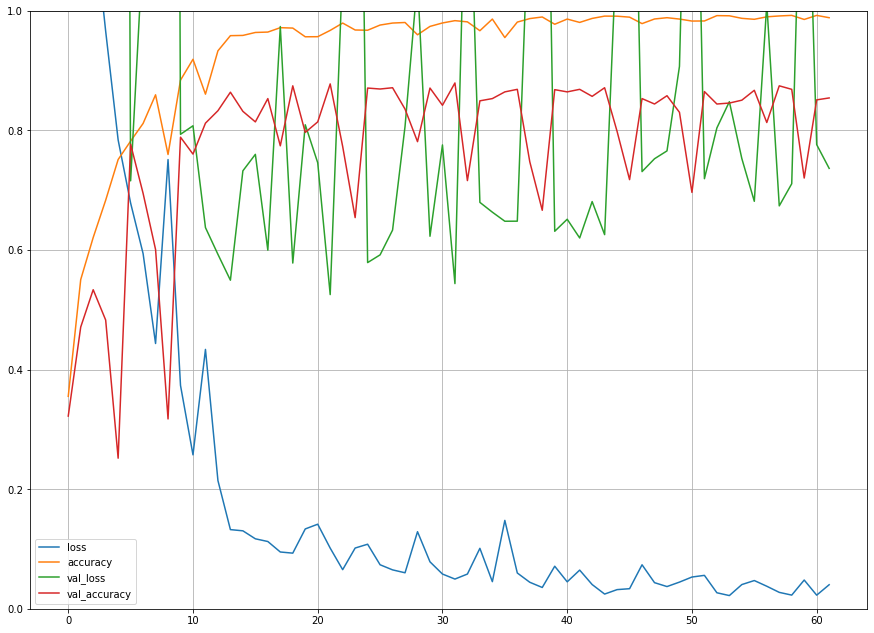

In [ ]:
pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_2.save("models/model_2.h5")
model_2.evaluate(X_test, y_test)

33/33 [==============================] - 3s 56ms/step - loss: 0.7233 - accuracy: 0.8607


[0.7233235239982605, 0.860710859298706]

In [ ]:
model_2_ = keras.models.load_model("models/model_2_best.h5")
model_2_.evaluate(X_test, y_test)

33/33 [==============================] - 2s 55ms/step - loss: 0.6019 - accuracy: 0.8713


[0.6018834114074707, 0.8712776303291321]

In [ ]:
import gc
gc.collect()
tf.keras.backend.clear_session()

# Finalization